# Noise sources from experimental measurement

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [23]:
import os
import itertools
import cloudpickle

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy as sp

# Interesting package to compute distributions using the power of Numba and
# Rmath. This should speed up the calculations required for this package
# http://quantecon.github.io/rvlib/


# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/experimental_noise_sources/'
datadir = '../../data/csv_maxEnt_dist/'

# $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$

## Added noise from experimental measurements.

When we experimentally "measure" the protein expression level distribution of our reporter what we actually measure is a noisy representation of this distribution via our measurement instrument. This constraints the information we can infer from our indirect measurement with respect to the real distribution. In particular in information theory the **data processing inequality** tells us that given a Markov chain of the form
$$
X \rightarrow Y \rightarrow Z,
$$
where $X, Y$ and $Z$ are random variables, the mutual information between variables should satisfy
$$
I(X; Z) \leq I(X; Y).
\label{eq:dpi}
$$
In other words, the information cannot be created. If we measure an indirect representation $Z$ of our quantity of interest $Y$, at best we can obtain the exact amount of information about $X$ if there is a deterministic mapping between $Y$ and $Z$. 

What this means is that if we define the chain to be
$$
[\text{inducer}] \rightarrow \text{protein} \rightarrow \text{fluorescence},
$$
our experimental signal can only have at best the same information about the inducer input as the protein itself has. For Eq \ref{eq:dpi} to become an equality we would need a deterministic relationship between protein copy number $p$ and fluorescence intensity $F$. For example linear relationship of the form
$$
F(p) = \alpha p,
$$
where $\alpha$ is the conversion factor between arbitrary units (a.u.) of fluroescence and absolute protein count.

In reality this relationship must be probabilistic, i.e.
$$
P(F \mid p) \sim f(p, \alpha).
$$

The sources of added noise could be
- Emission of photons per fluorescent molecule.
- Quantum efficiency of camera detector.
- Variability in laser light intensity.

As a first approximation let's ignore all the instrument related sources of noise and let's focus on the random emission of photons $\nu$ by a single fluorescent molecule. This quantity depends on the nature of the fluorophore, the light source and the exposure time.

### Poission Emission of Photons

A simple model to account for this added noise is to assume that every time that a fluorophore is excited it emits a photon count $\nu$ such that $\nu \sim \text{Poiss}(\lambda)$, i.e.
$$
P(\nu) = {\lambda^\nu e^{-\lambda} \over \nu!},
$$
where $\lambda = \ee{\nu}$ is the mean number of photons that the protein produces when excited.

If a measured cell has $p$ proteins that emit photons independently of each other, then the total photon count of a cell $N$ is given by
$$
N = \sum_{i=0}^p \nu_i \sim \text{Poiss}(p\lambda).
$$
What this says is that the sum of $p$ iid Poisson random variables with mean $\lambda$ have a Poission distribution with mean $p \lambda$. This statement can be easily proved using MGFs.

This implies that the distribution of fluorescent values per cell we observe $P(N \mid c)$, where $c$ is the inducer concentration are of the form
$$
P(N \mid c) = \sum_{p=0}^\infty P(N \mid p, c) P(p \mid c).
\label{eq:photon_dist}
$$

Since $N$ does not depend directly on $c$ but through the dependence of $p$ on $c$ we have that the first term on the right hand side is our Poisson
$$
P(N \mid p, c) = P(N \mid p) =
{(p \lambda)^N e^{-p\lambda} \over N!}.
$$

#### Coding Poission noise. 

Let's now define a function such that given a value for $\lambda$ it takes our MaxEnt protein distribution and maps it into Eq. \ref{eq:photon_dist}.

In [28]:
def photons_poisson(lam, mRNA, protein, lagrange,
                     exponents=[(1, 0), (2, 0), (3, 0),
                                (0, 1), (0, 2), (1, 1)], log=False):
    '''
    Computes the photon count distribution P(N) given a poission emission of
    photons per fluorophore with mean photon count per protein performing a
    convolution between the Poisson emission of photons with the MaxEnt protein
    distribution.
    
    Parameters
    ----------
    lam : float.
        Mean number of photon counts per protein.
    mRNA, protein : array-like.
        Sample space for both the mRNA and the protein.
    lagrange : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    exponents : list. leng(exponents) == len(lagrange)
        List containing the exponents associated with each constraint.
        For example a constraint of the form <m**3> has an entry (3, 0)
        while a constraint of the form <m * p> has an entry (1, 1).
    log : bool. Default = False
        Boolean indicating if the log probability should be returned.
        
    Returns
    -------
    Pmp : array-like.
        Photon count per cell distribution.
    '''
    
    # Compute the MaxEnt mRNA-protein joint distribution
    Pmp = chann_cap.maxEnt_from_lagrange(mRNA, protein, lagrange, exponents, log)
    
    # Marginalize out the mRNA to obtain the protein distribution
    Pp = np.sum(Pmp, axis=1)
    
    # Generate array of photon counts
    photons = np.arange(0, max(protein) * 2)
    
    # Initialize matrix to save the joint distribution P(N, p)
    PNp = np.zeros([len(protein), len(photons)])
       
    # Compute the distribution P(N | p) * P(p) for each protein count
    for i, p in enumerate(protein):
        PNp[i, :] = sp.stats.poisson.pmf(photons, p) * Pp[i]
        
    # Marginalize out the protein counts and return photon distribution
    return photons, np.sum(PNp, axis=0)

Now that we coded up this distribution let's look at the distribution using the MaxEnt inferences made for the experimentally available strains.

In [25]:
# Read MaxEnt infered Lagrange multipliers
df_maxEnt = pd.read_csv(datadir + 'MaxEnt_ss_Lagrange_multipliers_HGRP_2011.csv',
                        index_col=0)

df_maxEnt.head()

,operator,binding_energy,repressor,inducer_uM,lambda_m1p0,lambda_m2p0,lambda_m3p0,lambda_m0p1,lambda_m0p2,lambda_m0p3,lambda_m1p1,lambda_m2p1,lambda_m1p2
0,O1,-15.3,0.0,0.0,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10
1,O1,-15.3,0.0,0.1,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10
2,O1,-15.3,0.0,1.0,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10
3,O1,-15.3,0.0,5.0,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10
4,O1,-15.3,0.0,7.5,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10


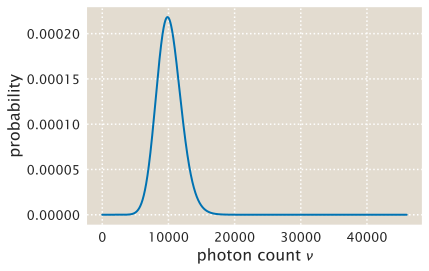

In [31]:
# Define sample space
mRNA_space = np.arange(0, 40)
protein_space = np.arange(0, 2.3E4)

# Extract inference from data frame
df_sample = df_maxEnt[(df_maxEnt.operator == 'O2') &
                      (df_maxEnt.repressor == 260) &
                      (df_maxEnt.inducer_uM == 75)]

# Select the Lagrange multipliers
lagrange_sample =  df_sample.loc[:, [col for col in df_sample.columns 
                                     if 'lambda' in col]].values[0]

# Compute distribution from Lagrange multipliers values
# photons, PN = photons_poisson(1000, mRNA_space, protein_space, lagrange_sample,
#                               exponents=[(1, 0), (2, 0), (3, 0), 
#                                          (0, 1), (0, 2), (0, 3),
#                                          (1, 1), (2, 1), (1, 2)])

plt.plot(photons, PN)
plt.xlabel(r'photon count $\nu$')
plt.ylabel('probability')

## Speeding up calculation

Given tat this computation is incredibly slow I searched online if there was a better implementation for the computation of these distributions. There is a package called [`rvlib`](http://quantecon.github.io/rvlib/), but unfortunately for some reason this library requires Python 3.5 (and I'm using 3.6)